<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/mlem_nso_1125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse

!pip install wandb
import wandb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from scipy.stats.mstats import winsorize

import random

def compute_p_y_given_z(Y, Theta, dist, reg=1e-3):
  
  """ Returns NxC
  p(y_n | z_n = c)
  """
  
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma']) + reg

  if dist == 'normal':
    dist_Y = D.Normal(loc=mu, scale=sigma)
  elif dist == 'student':
    dist_Y = D.StudentT(df=torch.tensor([2.0]), loc=mu, scale=sigma)

  return dist_Y.log_prob(Y.reshape(-1, 1, NF)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta, dist, reg=1e-3):
  
  """ Returns NxC
  p(s_n | z_n = c)
  """
  
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega']) + reg

  if dist == 'normal':
    dist_S = D.Normal(loc=psi, scale=omega)
  elif dist == 'student':
    dist_S = D.StudentT(df=torch.tensor([2.0]), loc=psi, scale=omega)

  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta, dist, reg=1e-3):
  
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma']) + reg

  mu2 = mu.reshape(1, NC, NF)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, NC, NF)
  sigma2 = (sigma2 + sigma2.permute(1, 0, 2)) / 2.0

  if dist == 'normal':
    dist_Y2 = D.Normal(loc=mu2, scale=sigma2)
  elif dist == 'student':
    dist_Y2 = D.StudentT(df=torch.tensor([2.0]), loc=mu2, scale=sigma2)

  return dist_Y2.log_prob(Y.reshape(-1, 1, 1, NF)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta, dist, reg=1e-3):
  
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega']) + reg

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  if dist == 'normal':
    dist_S2 = D.Normal(loc=psi2, scale=omega2)
  elif dist == 'student':
    dist_S2 = D.StudentT(df=torch.tensor([2.0]), loc=psi2, scale=omega2)

  return dist_S2.log_prob(S.reshape(-1, 1, 1))

def _ics(logL, n_obs, n_features, n_clusters, incCellSize): #, n, p, c
  param_mu = n_clusters * n_features
  param_sigma = n_clusters * n_features
  
  param_delta = 1
  param_pi = n_clusters - 1
  param_tau = ((n_clusters * n_clusters) - n_clusters)/2 + n_clusters - 1
  
  params = param_mu + param_sigma + param_delta + param_pi + param_tau

  if incCellSize:
    param_psi = n_clusters
    param_omega = n_clusters
    params += (param_psi + param_omega)
  
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

def ll(Y, S, Theta, dist, incCellSize):
  
  """compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """

  log_pi = F.log_softmax(Theta['is_pi'], 0)
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1), 0).reshape(NC,NC)
  log_delta = F.log_softmax(Theta['is_delta'], 0)

  ## singlet calculation
  p_y_given_z = compute_p_y_given_z(Y, Theta, dist)
  p_data_given_z_d0 = p_y_given_z + log_pi

  if incCellSize: # cellsize case
    p_s_given_z = compute_p_s_given_z(S, Theta, dist)
    p_data_given_z_d0 += p_s_given_z
  
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  ## doublet calculation
  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta, dist)

  if incCellSize: # cellsize case
    p_s_given_gamma = compute_p_s_given_gamma(S, Theta, dist)
    p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(Y.shape[0], -1)
  else:
    p_data_given_gamma_d1 = (p_y_given_gamma + log_tau).reshape(Y.shape[0], -1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)

  return torch.logsumexp(p_data, dim=1).mean()

def compute_r_v_2(Y, S, Theta, dist, incCellSize):
  
  """Need to compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  
  #lookups = np.triu_indices(nc) # wanted indices

  log_pi = F.log_softmax(Theta['is_pi'], 0)
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1), 0).reshape(NC,NC)
  log_delta = F.log_softmax(Theta['is_delta'], 0)

  ## singlet calculation
  p_y_given_z = compute_p_y_given_z(Y, Theta, dist)
  p_data_given_z_d0 = p_y_given_z + log_pi

  if incCellSize: # singlet case
    p_s_given_z = compute_p_s_given_z(S, Theta, dist)
    p_data_given_z_d0 += p_s_given_z
  
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  ## doublet calculation
  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta, dist)
  
  if incCellSize: # doublet case
    p_s_given_gamma = compute_p_s_given_gamma(S, Theta, dist)
    p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(Y.shape[0], -1)
  else:
    p_data_given_gamma_d1 = (p_y_given_gamma + log_tau).reshape(Y.shape[0], -1)
  
  ## LL
  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  p_data = torch.logsumexp(p_data, dim=1)

  ## singlet & doublet probability
  r = p_data_given_z_d0.T + log_delta[0] - p_data
  v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  ## normalize
  p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  return r.T, v.T.reshape(-1, NC, NC), p_data, p_singlet

def mlem_ycs(Y, S, Theta, dist):
  
  wandb.init(project="mlem_{}_nc{}".format(PROJECT_NAME, NC))
  
  lookups = np.triu_indices(NC) # wanted indices
  uwanted = np.tril_indices(NC, -1)
  
  opt = optim.Adam(Theta.values(), lr=LEARNING_RATE)
  
  XX = torch.hstack((Y, S.reshape(-1,1))).float()
  trainloader = DataLoader(torch.tensor(XX), batch_size=BATCH_SIZE, shuffle=True)
  #validloader = DataLoader(valid, batch_size=1280, shuffle=False)
  #testloader = DataLoader(test, batch_size=1280, shuffle=False)
    
  loss = []
  for epoch in range(N_ITER):
    
    nlls = 0
    for j, train_batch in enumerate(trainloader):
      
      bY = train_batch[:,:NF]
      bS = train_batch[:,NF]
      
      opt.zero_grad()  
      nll = -ll(bY, bS, Theta, dist, incCellSize=True)
      nll.backward()
      opt.step()
            
      nlls += nll.detach()

    with torch.no_grad():
      
      aic, bic = _ics(-nlls, Y.shape[0], NF, NC, incCellSize=True) #, n, p, c

      wandb.log({
        'nll': nlls, 
        'AIC': aic,
        'BIC': bic,
      })

      if epoch > 5 and abs((np.mean(loss[-10:]) - np.mean(loss[-11:-1]))/np.mean(loss[-10:])) < TOL:
      #if epoch > 5 and abs(np.mean(loss[-10:]) - np.mean(loss[-11:-1])) < TOL:
        #print(nlls)
        #print(F.softmax(Theta['is_delta'], 0).exp())
        #print(Theta['log_psi'].exp())
        break
            
      loss.append(nlls)
    
  with torch.no_grad():
    r, v, L, p_singlet = compute_r_v_2(Y, S, Theta, dist, True)

    ugt = torch.tensor(v[:,lookups[0], lookups[1]]).exp()
    lt = torch.tensor(v[:,uwanted[0], uwanted[1]]).exp()
    ugt[:,lookups[0] != lookups[1]] = ugt[:,lookups[0] != lookups[1]] + lt             
    p_cluster = torch.hstack((ugt, torch.tensor(r).exp()))

  return p_singlet, p_cluster

In [2]:
!pip install scanpy
import scanpy as sc

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
## mouse data
#adata = sc.read_h5ad("DAMM/data/mouse_single_cell_expression.h5ad")
#adata = sc.read_h5ad("DAMM/data/mouse_1000.h5ad")
adata = sc.read_h5ad("DAMM/data/mouse_single_cell_expression_dc.h5ad")

included_names = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
 'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'FOXP3', 'GATA3', 'GFP', 
 'GranzymeB', 'HA', 'ICOS', 'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 
 'Perforin', 'RFP', 'S100A8-9', 'TBET', 'TCF1', 'YAP', 'iNOS']
SS = adata.obs['size']

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [ ]:
#cell_sel = np.random.choice(adata.shape[0], size=5000)
#adata[cell_sel,:].write_h5ad(filename='DAMM/data/mouse_5k.h5ad')

In [44]:
## human data
#adata = sc.read_h5ad("DAMM/data/basel_zuri_subsample.h5ad")
adata = sc.read_h5ad("DAMM/data/basel_zuri.h5ad")
included_names = ['EGFR', 'ECadherin', 'ER', 'GATA3', 'Histone_H3_1', 'Ki67', 'SMA', 
'Vimentin', 'cleaved_Parp', 'Her2', 'p53', 'panCytokeratin', 'CD19', 'PR', 'Myc', 
'Fibronectin', 'CK14', 'Slug', 'CD20', 'vWF', 'Histone_H3_2', 'CK5', 'CD44', 'CD45', 
'CD68', 'CD3', 'CAIX', 'CK8/18', 'CK7', 'phospho Histone', 'phospho S6', 'phospho mTOR']

cell_sel = np.random.choice(adata.shape[0], size=10000)
adata = adata[cell_sel,:]

SS = adata.obs['Area'] ## for human data

In [45]:
adata = adata[:,included_names]
#adata = adata[adata.obs['size'] > 20,:]

YY = adata.X.copy()
#YY = np.array(np.arcsinh(YY / 5.))

NO, NF = YY.shape #number obs & features 

for i in range(NF):
  YY[:,i] = winsorize(YY[:,i], limits=[0, 0.01]).data

SS = winsorize(SS, limits=[0, 0.01]).data

In [46]:
#N_training = 5000
idx_singlet = np.random.choice(adata.shape[0], size=NO)
Y_singlet = YY[idx_singlet,:] ## expression
S_singlet = SS[idx_singlet]

idx_doublet = [np.random.choice(adata.shape[0], size=NO), np.random.choice(adata.shape[0], size=NO)]
Y_doublet = (YY[idx_doublet[0],:] + YY[idx_doublet[1],:])/2.
S_doublet = SS[idx_doublet[0]] + SS[idx_doublet[1]]

fake_Y = torch.tensor(np.vstack([Y_singlet, Y_doublet]))
fake_S = torch.tensor(np.hstack([S_singlet, S_doublet]))
fake_label = torch.tensor(np.concatenate([np.ones(NO), np.zeros(NO)]))

In [54]:
NC = 10 # number of clusters
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
N_ITER = 100
TOL = 1e-3 #converagence criterion
lam = .01

fake_loss = nn.BCELoss()

## w&b api key
wandb.login(key='4117bb00bef94e0904c16afed79f1888e0839eb9')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [55]:
Y = torch.tensor(YY)
S = torch.tensor(SS)

kms = KMeans(NC).fit(Y)
init_labels = kms.labels_
init_label_class = np.unique(init_labels)

mu_init = np.array([YY[init_labels == c,:].mean(0) for c in init_label_class])
sigma_init = np.array([YY[init_labels == c,:].std(0) for c in init_label_class])

psi_init = np.array([SS[init_labels == c].mean() for c in init_label_class])
omega_init = np.array([SS[init_labels == c].std() for c in init_label_class])

pi_init = np.array([np.mean(init_labels == c) for c in init_label_class])
tau_init = np.ones((NC,NC))
tau_init = tau_init / tau_init.sum()

Theta = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    'is_delta': np.log([0.95, 0.05]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init),

}

Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}
Theta['is_delta'].requires_grad = False

In [56]:
dist = "student"
opt = optim.Adam(Theta.values(), lr=LEARNING_RATE)

#XX = torch.hstack((Y, S.reshape(-1,1))).float()
#fake_XX = torch.hstack((fake_Y, fake_S.reshape(-1,1))).float()

#trainloader = DataLoader(torch.tensor(XX), batch_size=BATCH_SIZE, shuffle=True)
#validloader = DataLoader(valid, batch_size=1280, shuffle=False)
#testloader = DataLoader(test, batch_size=1280, shuffle=False)

In [57]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

train_loader = torch.utils.data.DataLoader(ConcatDataset(Y, S, fake_Y, fake_S, fake_label), batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
PROJECT_NAME = 'mlem_human_nso_ycs_fakeData_stuT'
wandb.init(project="mlem_{}_nc{}".format(PROJECT_NAME, NC))

In [ ]:
  loss = []
  for epoch in range(N_ITER):
    
    #print(epoch)

    nlls = 0; flos = 0; tlos = 0
    for j, (bY, bS, bfY, bfS, bfl) in enumerate(train_loader):

      opt.zero_grad()  
      nll = -ll(bY, bS, Theta, dist, True)

      _, _, _, p_fake_singlet = compute_r_v_2(bfY, bfS, Theta, dist, True)
      floss = -fake_loss(p_fake_singlet, bfl) * lam

      #if j % 10 == 0:
      #  print("nll {}; floss {}".format(nll, floss))
      
      closs = nll + floss
      closs.backward()
      opt.step()
      
      nlls += nll.detach()
      flos += floss.detach()
      tlos += nll.detach() + floss.detach()

    with torch.no_grad():
      
      #aic, bic = _ics(-nlls, Y.shape[0], NF, NC, incCellSize=True) #, n, p, c

      wandb.log({
        'nll': nlls, 
        'fake_loss': flos,
        'total_loss': tlos,
        #'AIC': aic,
        #'BIC': bic,
      })

      if epoch > 10 and abs(np.mean(loss[-5:]) - np.mean(loss[-6:-1])) < TOL:
        break
      
      print("epoch {}; total loss {}".format(epoch+1, tlos))

      loss.append(tlos)

In [60]:
with torch.no_grad():
  r, v, L, p_singlet = compute_r_v_2(Y, S, Theta, dist, True)
  print(sum(p_singlet > .5)/len(p_singlet))

tensor(0.5771)


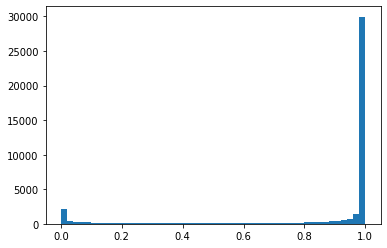

In [ ]:
plt.hist(p_singlet.detach().numpy(), bins=50);

In [ ]:
y_pred = np.array([0.1580, 0.4137, 0.2285])
y_true = np.array([0.0, 1.0, 0.0]) #2 labels: (0,1)
def BCE(y_pred, y_true):
    total_bce_loss = np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
    # Getting the mean BCE loss
    num_of_samples = y_pred.shape[0]
    mean_bce_loss = total_bce_loss / num_of_samples
    return mean_bce_loss
bce_value = BCE(y_pred, y_true)
print ("BCE error is: " + str(bce_value))

bce_loss = torch.nn.BCELoss()
sigmoid = torch.nn.Sigmoid() # Ensuring inputs are between 0 and 1
input = torch.tensor(y_pred)
target = torch.tensor(y_true)
output = bce_loss(input, target)
output